Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

##### Importing all the important libraries


In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img
from glob import glob


##### If you are using the data by mounting the google drive, use the following :
##### from google.colab import drive
##### drive.mount('/content/gdrive')
##### Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166:


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/data/' 

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

##### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

In [3]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("gdrive/My Drive/data/Train")
data_dir_test =  pathlib.Path("gdrive/My Drive/data/Test")

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.


In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(data_dir_train,
                                                       image_size=(img_height, img_width),
                                                       seed=123,
                                                       validation_split=0.2,
                                                       subset="training",
                                                      label_mode='categorical')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(data_dir_train,image_size=(img_height, img_width),
                                                     seed=123,
                                                     validation_split=0.2,
                                                     subset="validation",
                                                     label_mode='categorical')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
test_ds = tf.keras.utils.image_dataset_from_directory(data_dir_test,image_size=(img_height, img_width),
                                                     seed=123,                                                     
                                                     label_mode='categorical')

Found 118 files belonging to 9 classes.


In [9]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


##### Data Viuaslization

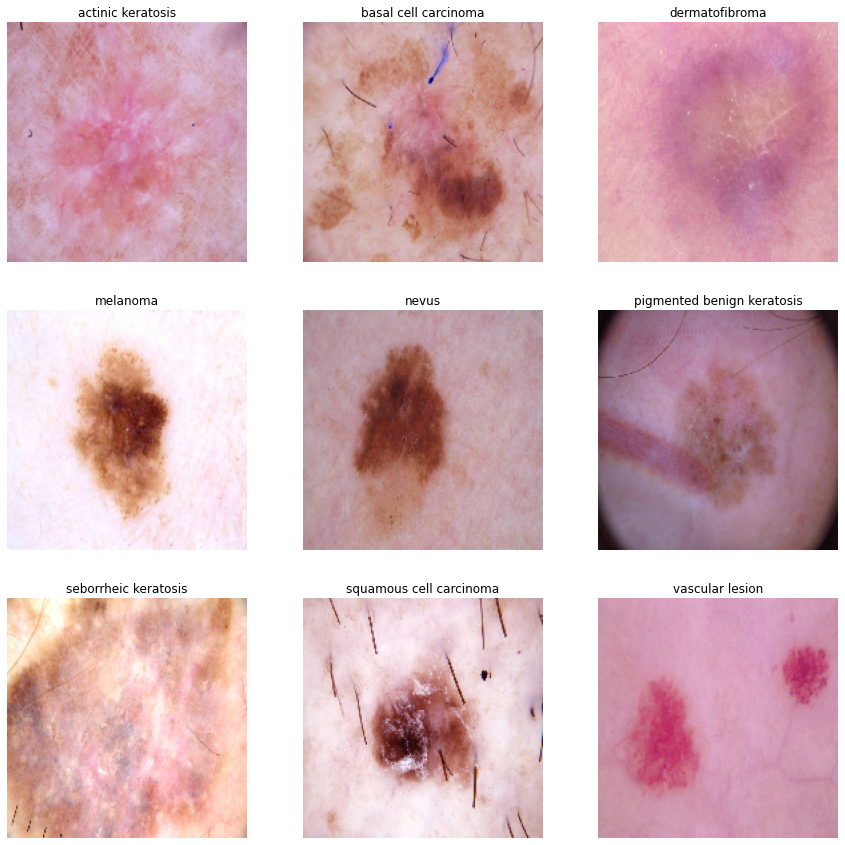

In [10]:
### your code goes here, you can use training or validation data to visualize
filePath = {}
for c in class_names:
    filePath[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))
    #print(filePath[c])
    
#Visualize image
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = filePath[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Model A: Base Model

### Create the model
Creation a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
#Create model 
model1 = Sequential()

#Normalize pixel values between (0,1)
model1.add(layers.experimental.preprocessing.Rescaling(1.0/255.00,input_shape=(180,180,3)))   

#First Convulation layer
model1.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu', padding='same'))
model1.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer 
model1.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu', padding='same'))
model1.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer 
model1.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu', padding='same'))
model1.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer
model1.add(layers.Dropout(0.30))

#Flatten Layer
##Multi-dimensional input tensors into a single dimension.
model1.add(layers.Flatten())

#Dense Layer
model1.add(layers.Dense(128,activation='relu'))

#Dropout layer with 30% units to drop.
model1.add(layers.Dropout(0.30))

#Dense Layer with softmax activation function.
model1.add(layers.Dense(len(class_names),activation='softmax'))


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [13]:
model1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 128)       7

##### Train the First *model*

In [15]:
epochs = 20
history = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 567s 2s/step - loss: 2.0744 - accuracy: 0.2098 - val_loss: 1.9379 - val_accuracy: 0.2327
Epoch 2/20
56/56 [==============================] - 2s 43ms/step - loss: 1.7115 - accuracy: 0.3962 - val_loss: 1.5423 - val_accuracy: 0.4832
Epoch 3/20
56/56 [==============================] - 2s 43ms/step - loss: 1.5719 - accuracy: 0.4526 - val_loss: 1.5027 - val_accuracy: 0.5011
Epoch 4/20
56/56 [==============================] - 2s 43ms/step - loss: 1.4418 - accuracy: 0.4994 - val_loss: 1.4428 - val_accuracy: 0.4832
Epoch 5/20
56/56 [==============================] - 2s 43ms/step - loss: 1.3557 - accuracy: 0.5424 - val_loss: 1.3841 - val_accuracy: 0.5459
Epoch 6/20
56/56 [==============================] - 2s 43ms/step - loss: 1.2887 - accuracy: 0.5525 - val_loss: 1.3791 - val_accuracy: 0.5347
Epoch 7/20
56/56 [==============================] - 3s 46ms/step - loss: 1.2749 - accuracy: 0.5575 - val_loss: 1.3892 - val_accuracy: 0.5190
Epoch 8/20
56

#### Visualize Results

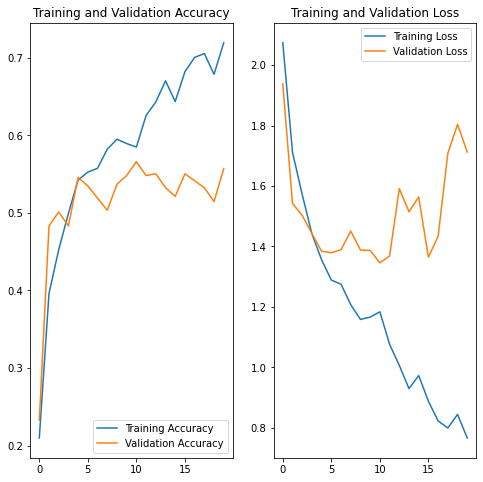

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Findings for Model A: Base model**: 

#### Training accuracy : High
#### Training loss :is low
#### Validation accuracy:  is low
#### Validation loss:  in high
#### Clearly it is overfitting 

**Model Manual Augmentation Layer**: Adding Data Augmentation layer

In [17]:
## Create the model

model_manual_aug = Sequential()

#Rescaling Layer
model_manual_aug.add(layers.experimental.preprocessing.Rescaling(1.0/255.00,input_shape=(180,180,3)))   

model_manual_aug.add(tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(0.2),
 
])) 

#First Convulation layer
model_manual_aug.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu', padding='same'))
model_manual_aug.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model_manual_aug.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu', padding='same'))
model_manual_aug.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model_manual_aug.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu', padding='same'))
model_manual_aug.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer
model_manual_aug.add(layers.Dropout(0.30))

#Flatten Layer
##flattens the multi-dimensional input tensors into a single dimension.
model_manual_aug.add(layers.Flatten())

#Dense Layer
model_manual_aug.add(layers.Dense(128,activation='relu'))

#Dropout layer
model_manual_aug.add(layers.Dropout(0.30))

#Dense Layer
model_manual_aug.add(layers.Dense(len(class_names),activation='softmax'))

In [18]:
# Summary of all layers
model_manual_aug.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                  

In [19]:
# compile
model_manual_aug.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [20]:
#train
epochs = 20
history_manual_aug = model_manual_aug.fit(
                                            train_ds,
                                            validation_data=val_ds,
                                            epochs=epochs
                                          )

Epoch 1/20
56/56 [==============================] - 5s 73ms/step - loss: 2.1245 - accuracy: 0.2533 - val_loss: 1.8144 - val_accuracy: 0.4139
Epoch 2/20
56/56 [==============================] - 4s 70ms/step - loss: 1.7598 - accuracy: 0.3655 - val_loss: 1.6263 - val_accuracy: 0.4497
Epoch 3/20
56/56 [==============================] - 4s 68ms/step - loss: 1.6429 - accuracy: 0.4107 - val_loss: 1.5548 - val_accuracy: 0.4720
Epoch 4/20
56/56 [==============================] - 4s 69ms/step - loss: 1.5696 - accuracy: 0.4464 - val_loss: 1.4759 - val_accuracy: 0.4765
Epoch 5/20
56/56 [==============================] - 4s 69ms/step - loss: 1.4743 - accuracy: 0.4754 - val_loss: 1.4543 - val_accuracy: 0.5056
Epoch 6/20
56/56 [==============================] - 4s 69ms/step - loss: 1.4843 - accuracy: 0.4743 - val_loss: 1.4719 - val_accuracy: 0.5056
Epoch 7/20
56/56 [==============================] - 4s 69ms/step - loss: 1.4231 - accuracy: 0.4967 - val_loss: 1.4550 - val_accuracy: 0.5145
Epoch 8/20
56

#### Visualize the results

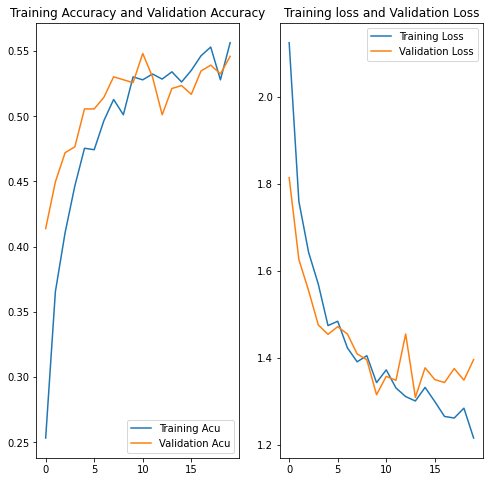

In [21]:
acc = history_manual_aug.history['accuracy']
val_acc = history_manual_aug.history['val_accuracy']

loss = history_manual_aug.history['loss']
val_loss = history_manual_aug.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Acu')
plt.plot(epochs_range, val_acc, label='Validation Acu')
plt.legend(loc='lower right')
plt.title('Training Accuracy and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training loss and Validation Loss')
plt.show()

### **Findings for Model B with manual augmentation layer:** 
#### Train Accuracy: low
#### Train loss: high
#### Test Accuracy: low
#### Test loss: high than train
#### Hence it is clearly underfitting

### Write your findings here after the model fit, see if there is an evidence of model overfit or underfit

**Findings**: It is overfitting clearly as training accuracy is high  and validation accuracy is very low

#### **Data Distribution:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [22]:
path_list=[]
lesion_list=[]

for i in class_names:
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
df_dict = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(df_dict.items()),columns = ['Path','Label'])
print(original_df.Label.value_counts())    

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64


#### visualize class distribution

Text(0.5, 1.0, 'Images per class')

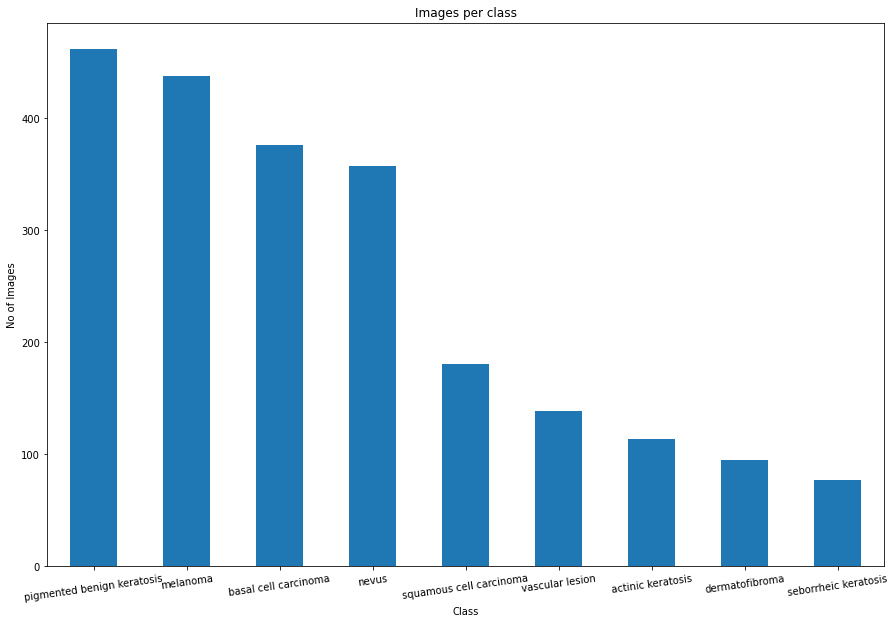

In [23]:
original_df.Label.value_counts().plot(kind='bar', figsize=(15, 10), rot=8)
plt.xlabel("Class")
plt.ylabel("No of Images")
plt.title("Images per class")

#### **Visualization Interpretation**: 
#### - Which class has the least number of samples?
#### - ***Sebarrohic keratosis***
#### - Which classes dominate the data in terms proportionate number of samples?
#### - ***Pigmented beningn keratosis***

#### **Solution:** Rectify the class imbalance
##### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [24]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.

In [25]:
data_dir_train1  = str(data_dir_train) + "//"
import Augmentor
for i in class_names:
    ##print(str(path_to_training_dataset) + '\\' +i)
    p = Augmentor.Pipeline(data_dir_train1 + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)
    ##p.process

Initialised with 114 image(s) found.
Output directory set to gdrive/My Drive/data/Train//actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6DCA9F5990>: 100%|██████████| 500/500 [00:22<00:00, 22.60 Samples/s]


Initialised with 376 image(s) found.
Output directory set to gdrive/My Drive/data/Train//basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6DCAA75B50>: 100%|██████████| 500/500 [00:22<00:00, 21.82 Samples/s]


Initialised with 95 image(s) found.
Output directory set to gdrive/My Drive/data/Train//dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6ECD389E50>: 100%|██████████| 500/500 [00:23<00:00, 21.34 Samples/s]


Initialised with 438 image(s) found.
Output directory set to gdrive/My Drive/data/Train//melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F6DCA961E50>: 100%|██████████| 500/500 [01:41<00:00,  4.93 Samples/s]


Initialised with 357 image(s) found.
Output directory set to gdrive/My Drive/data/Train//nevus/output.

Processing <PIL.Image.Image image mode=RGB size=957x640 at 0x7F6DCAA75150>: 100%|██████████| 500/500 [01:27<00:00,  5.74 Samples/s]


Initialised with 462 image(s) found.
Output directory set to gdrive/My Drive/data/Train//pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6DCA801190>: 100%|██████████| 500/500 [00:19<00:00, 25.18 Samples/s]


Initialised with 77 image(s) found.
Output directory set to gdrive/My Drive/data/Train//seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F6DCB7D9310>: 100%|██████████| 500/500 [00:44<00:00, 11.13 Samples/s]


Initialised with 181 image(s) found.
Output directory set to gdrive/My Drive/data/Train//squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F6DCA8B2690>: 100%|██████████| 500/500 [00:19<00:00, 26.06 Samples/s]


Initialised with 139 image(s) found.
Output directory set to gdrive/My Drive/data/Train//vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F6DCA96D510>: 100%|██████████| 500/500 [00:19<00:00, 25.74 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [26]:
from glob import glob
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [27]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))


### Lets see the distribution of augmented data after adding new images to the original training data.


In [28]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

#### Train the model on the data created using *Augmentor*

#### Create a training dataset


In [29]:
train_ds= tf.keras.preprocessing.image_dataset_from_directory(
                                                                data_dir_train1,
                                                                seed=123,
                                                                validation_split = 0.2,
                                                                subset = "training",
                                                                image_size = (180, 180),
                                                                batch_size = 32
                                                               )

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


##### Create a validation dataset

In [30]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                                              data_dir_train1,
                                                              seed=123,
                                                              validation_split = 0.2,
                                                              subset = "validation",
                                                              image_size=(180, 180),
                                                              batch_size=32
                                                             )

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Model C: Model with Augmentation using Library**

In [31]:
#Sequential allows you to create models layer-by-layer  
model2_Augmentor = Sequential()

#Rescaling Layer
model2_Augmentor.add(layers.experimental.preprocessing.Rescaling(1.0/255.00,input_shape=(180,180,3)))   

#First Convulation layer
model2_Augmentor.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu', padding='same'))
model2_Augmentor.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model2_Augmentor.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu', padding='same'))
model2_Augmentor.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model2_Augmentor.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu', padding='same'))
model2_Augmentor.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer
model2_Augmentor.add(layers.Dropout(0.30))

#Flatten Layer
model2_Augmentor.add(layers.Flatten())

#Dense Layer
model2_Augmentor.add(layers.Dense(128,activation='relu'))

#Dropout layer
model2_Augmentor.add(layers.Dropout(0.30))

#Dense Layer
model2_Augmentor.add(layers.Dense(len(class_names),activation='softmax'))

In [32]:
# View the summary of all layers
model2_Augmentor.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 128)      

In [33]:
model2_Augmentor.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [34]:
#train the model
epochs = 30
history_Augmentor = model2_Augmentor.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/30
169/169 [==============================] - 36s 206ms/step - loss: 1.9317 - accuracy: 0.2856 - val_loss: 1.5412 - val_accuracy: 0.4543
Epoch 2/30
169/169 [==============================] - 34s 198ms/step - loss: 1.4719 - accuracy: 0.4436 - val_loss: 1.3118 - val_accuracy: 0.5338
Epoch 3/30
169/169 [==============================] - 35s 199ms/step - loss: 1.3016 - accuracy: 0.5124 - val_loss: 1.1971 - val_accuracy: 0.5620
Epoch 4/30
169/169 [==============================] - 36s 208ms/step - loss: 1.1840 - accuracy: 0.5504 - val_loss: 1.1280 - val_accuracy: 0.5947
Epoch 5/30
169/169 [==============================] - 34s 196ms/step - loss: 1.0807 - accuracy: 0.6031 - val_loss: 0.9867 - val_accuracy: 0.6407
Epoch 6/30
169/169 [==============================] - 35s 202ms/step - loss: 1.0025 - accuracy: 0.6335 - val_loss: 0.9286 - val_accuracy: 0.6555
Epoch 7/30
169/169 [==============================] - 34s 197ms/step - loss: 0.8810 - accuracy: 0.6810 - val_loss: 0.8672 - val_ac

#### Visualize the results 

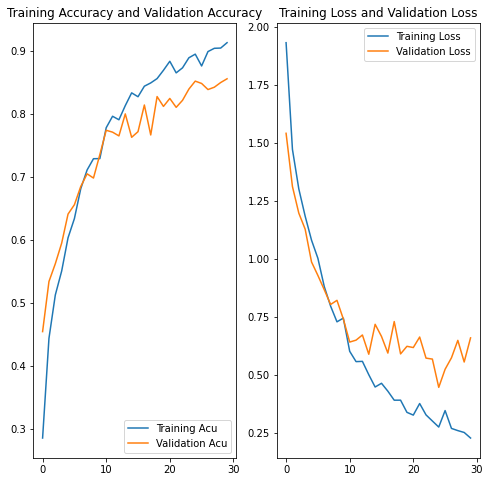

In [35]:
acc = history_Augmentor.history['accuracy']
val_acc = history_Augmentor.history['val_accuracy']

loss = history_Augmentor.history['loss']
val_loss = history_Augmentor.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Acu')
plt.plot(epochs_range, val_acc, label='Validation Acu')
plt.legend(loc='lower right')
plt.title('Training Accuracy and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training Loss and Validation Loss')
plt.show()

In [36]:

loss, accuracy = model2_Augmentor.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model2_Augmentor.evaluate(val_ds, verbose=1)


print("Accuracy            : ", accuracy)
print("Validation Accuracy : ",accuracy_v)

print(20*"-")
print("Loss                : ",loss)
print("Validation Loss     : ", loss_v)



43/43 [==============================] - 6s 122ms/step - loss: 0.6595 - accuracy: 0.8552
Accuracy            :  0.9515949487686157
Validation Accuracy :  0.8552338480949402
--------------------
Loss                :  0.13555563986301422
Validation Loss     :  0.6595426201820374


### **Findings for Model C using Augmentation Library:**
#### Training Accuracy: Good
#### Validation Accuracy : Good
#### Training loss: ok
#### Validation loss: okay.(not a huge variation from training loss)

#### Try other model D: Try dropout after conv layer and FC layer



In [37]:
#Sequential allows you to create models layer-by-layer  
model3 = Sequential()

#Rescaling Layer
model3.add(layers.experimental.preprocessing.Rescaling(1.0/255.00,input_shape=(180,180,3)))   

#First Convulation layer
model3.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu', padding='same'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))
model3.add(layers.Dropout(0.30))


#Second Convulation Layer
model3.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu', padding='same'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))
model3.add(layers.Dropout(0.30))


#Third Convulation Layer
model3.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu', padding='same'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))
model3.add(layers.Dropout(0.30))

#Flatten Layer
model3.add(layers.Flatten())

#Dense Layer
model3.add(layers.Dense(128,activation='relu'))

#Dropout layer
model3.add(layers.Dropout(0.30))

#Dense Layer
model3.add(layers.Dense(len(class_names),activation='softmax'))

In [38]:
# View the summary of all layers
model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 90, 90, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 64)       0         
 g2D)                                                 

In [39]:
model3.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [40]:
#train the model
epochs = 30
history_model3 = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 35s 195ms/step - loss: 2.3543 - accuracy: 0.1335 - val_loss: 2.1925 - val_accuracy: 0.1448
Epoch 2/30
169/169 [==============================] - 34s 194ms/step - loss: 2.0682 - accuracy: 0.2036 - val_loss: 1.8658 - val_accuracy: 0.2606
Epoch 3/30
169/169 [==============================] - 35s 200ms/step - loss: 1.8703 - accuracy: 0.2736 - val_loss: 1.6760 - val_accuracy: 0.3437
Epoch 4/30
169/169 [==============================] - 33s 192ms/step - loss: 1.6588 - accuracy: 0.3578 - val_loss: 1.5729 - val_accuracy: 0.4016
Epoch 5/30
169/169 [==============================] - 33s 191ms/step - loss: 1.4614 - accuracy: 0.4473 - val_loss: 1.3495 - val_accuracy: 0.5226
Epoch 6/30
169/169 [==============================] - 33s 191ms/step - loss: 1.3392 - accuracy: 0.5046 - val_loss: 1.3462 - val_accuracy: 0.5108
Epoch 7/30
169/169 [==============================] - 33s 190ms/step - loss: 1.2256 - accuracy: 0.5399 - val_loss: 1.1929 - val_ac

#### See the metrics

In [41]:
loss, accuracy = model3.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model3.evaluate(val_ds, verbose=1)

print("Accuracy            : ", accuracy)
print("Validation Accuracy : ",accuracy_v)
print(40*"-")
print("Loss                : ",loss)
print("Validation Loss     : ", loss_v)


43/43 [==============================] - 6s 124ms/step - loss: 0.5608 - accuracy: 0.8307
Accuracy            :  0.9434347152709961
Validation Accuracy :  0.8307349681854248
----------------------------------------
Loss                :  0.17780759930610657
Validation Loss     :  0.5608397126197815


##### SUMMARY 

##### Model A: Base Model - overfitting
##### Model B: Using Augmentation Layer - Underfitting
##### Model C: Using Augmentation library - Good one
##### Model D: Try some other tweakings - less better than model C

### Delete the output folders 

In [ ]:
try:
   for i in path_list_new:
     os.remove(i)
except OSError as error:
    print(error)
    print("File path can not be removed")